In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../fuzzy-torch') # or just install the module
sys.path.append('../../fuzzy-tools') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

In [2]:
from fuzzytools.files import search_for_filedirs
from lchandler import C_ as C_

surveys_rootdir = '../../surveys-save/'
filedirs = search_for_filedirs(surveys_rootdir, fext=C_.EXT_SPLIT_LIGHTCURVE)

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from fuzzytools.files import load_pickle, save_pickle
from fuzzytools.files import get_dict_from_filedir

method = 'spm-mcmc-estw'
filedir = f'../../surveys-save/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}.splcds'

filedict = get_dict_from_filedir(filedir)
root_folder = filedict['_rootdir']
cfilename = filedict['_cfilename']
survey = filedict['survey']
lcdataset = load_pickle(filedir)
print(lcdataset)

LCDataset:
[outliers - samples 10]
(.) obs_samples=541 - min_len=14 - max_dur=408.0[days] - dur(p50)=133.8[days] - cadence(p50)=1.0[days]
(g) obs_samples=260 - min_len=6 - max_dur=408.0[days] - dur(p50)=133.8[days] - cadence(p50)=3.0[days]
(r) obs_samples=281 - min_len=8 - max_dur=376.0[days] - dur(p50)=128.7[days] - cadence(p50)=3.0[days]
   |█▌      | SLSN - 2/10 (20.00%)
   |████    | SNII-b-n - 5/10 (50.00%)
   |▊       | SNIa - 1/10 (10.00%)
   |█▌      | SNIbc - 2/10 (20.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint - samples 48]
(.) obs_samples=1,107 - min_len=7 - max_dur=298.1[days] - dur(p50)=40.5[days] - cadence(p50)=1.0[days]
(g) obs_samples=450 - min_len=0 - max_dur=221.7[days] - dur(p50)=28.0[days] - cadence(p50)=2.9[days]
(r) obs_samples=657 - min_len=4 - max_dur=298.1[days] - dur(p50)=38.9[days] - cadence(p50)=2.9[days]
   |█▏      | SLSN - 7/48 (14.58%)
   |██▌     | SNII-b-n - 15/48 (31.25%)
   |███▊   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


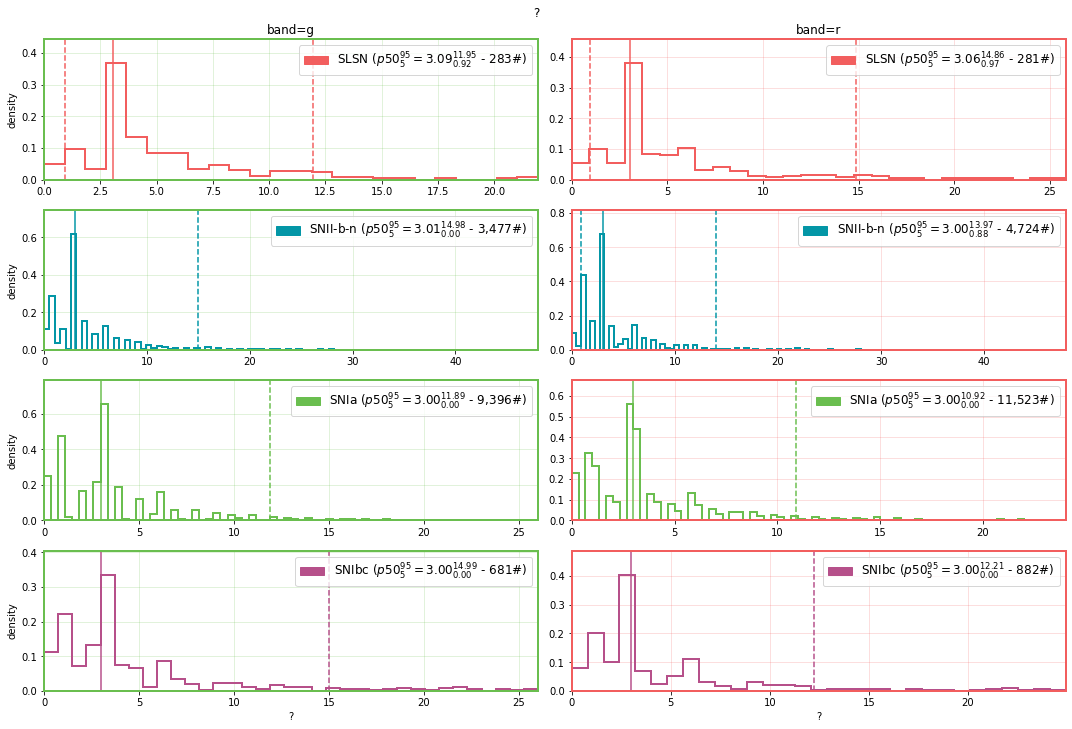

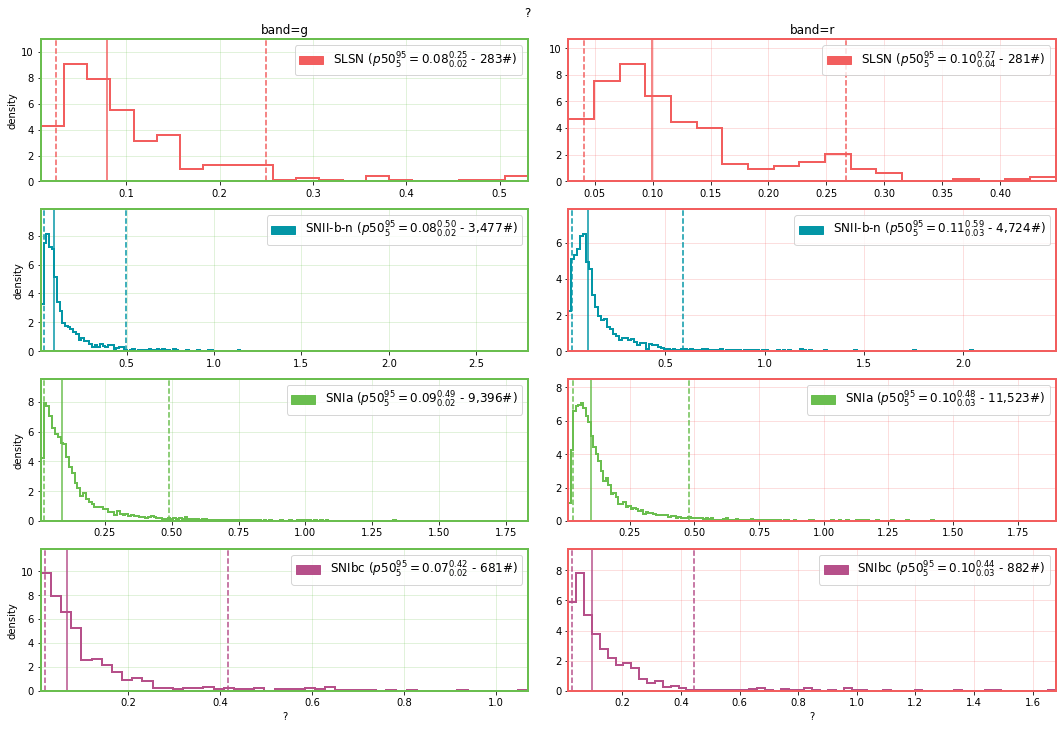

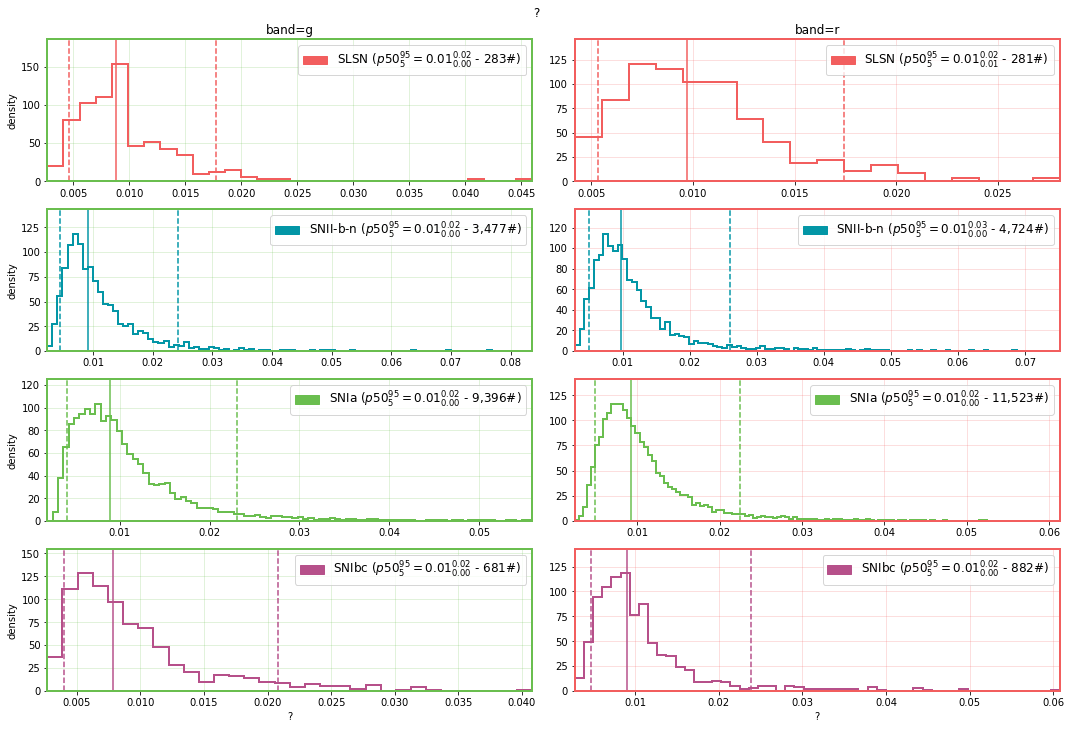

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from lchandler.plots.distrs import plot_values_distribution

kf = 0
set_name = f'{kf}@train'
lcdataset[set_name].set_diff_parallel('days')
plot_values_distribution(lcdataset, set_name, 'd_days')
plot_values_distribution(lcdataset, set_name, 'obs')
plot_values_distribution(lcdataset, set_name, 'obse')

In [5]:
%load_ext autoreload
%autoreload 2
from lcclassifier.datasets import CustomDataset

dataset_kwargs = {
    'max_day':100.,
}
#attrs':['days','obs', 'obse']
in_attrs = ['obs', 'obse']
#'attrs':['d_days','obs', 'obse']
rec_attr = 'obs'
train_dataset = CustomDataset(f'{kf}@train.{method}', lcdataset, in_attrs, rec_attr, **dataset_kwargs)
val_dataset = CustomDataset(f'{kf}@val', lcdataset, in_attrs, rec_attr, **dataset_kwargs)
train_dataset.transfer_scalers(val_dataset) # transfer metadata to val/test
print('train_dataset:', train_dataset)
print('val_dataset:', val_dataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
train_dataset: CustomDataset(lcset_len=13,968, class_names=['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc'], band_names=['g', 'r'], max_day=100.00, max_len=94, in_attrs=['obs', 'obse'], rec_attr=obs, append_in_ddays=False)
val_dataset: CustomDataset(lcset_len=387, class_names=['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc'], band_names=['g', 'r'], max_day=100.00, max_len=148, in_attrs=['obs', 'obse'], rec_attr=obs, append_in_ddays=False)


In [17]:
train_dataset[30]
#pass

{'input': {'s_onehot': tensor([[False,  True],
          [ True, False],
          [False,  True],
          [False,  True],
          [ True, False],
          [ True, False],
          [False,  True],
          [False,  True],
          [False,  True],
          [False,  True],
          [False,  True],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False, False],
          [False,

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(g:8) - [d:[14.69886935 16.69886935 20.69886935 24.69886935 26.69886935 30.69886935
 34.69886935 36.69886935]float64, o:[0.15090927 0.14641536 0.15452768 0.14525737 0.1299633  0.13514637
 0.12821274 0.12687852]float64, oe:[0.01417201 0.01346758 0.01489244 0.00753846 0.01404593 0.00778663
 0.0166231  0.00967008]float64]
(r:15) - [d:[ 0.  6.  8. 10. 12. 30. 32. 36. 40. 44. 50. 54. 56. 58. 60.]float64, o:[0.05881378 0.09718899 0.10321475 0.11558698 0.12876072 0.12118946
 0.1191677  0.09719975 0.10763009 0.10236719 0.07975305 0.07224077
 0.06788834 0.06956476 0.05198732]float64, oe:[0.00613029 0.01165376 0.01125394 0.01006609 0.0076342  0.00813815
 0.00982309 0.02249205 0.00908338 0.01183936 0.00746333 0.00987464
 0.00642276 0.00911773 0.01062439]float64]
(*:23) - [d:[ 0.          6.          8.         10.         12.         14.69886935
 16.69886935 20.69886935 24.69886935 26.69886935 30.         30.6

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


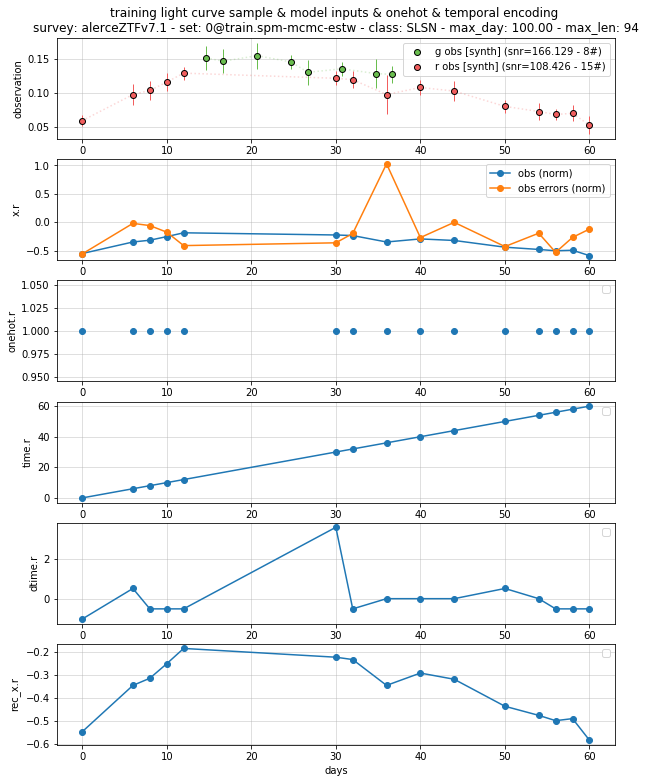

In [6]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from lchandler.plots.lc import plot_lightcurve
from lchandler import C_ as C_
import cProfile
%matplotlib inline

dataset = train_dataset
lcobj_name = dataset.get_random_stratified_lcobj_names()[0]

p = cProfile.Profile()
p.enable()
tdict, lcobj = dataset.get_item(lcobj_name, uses_len_clip=False, uses_daugm=False, return_lcobjs=True)
print(lcobj)
p.disable()
p.dump_stats('prof.prof')

minput = tdict['input']
target = tdict['target']

figsize = (10,13)
fig, axs = plt.subplots(5+1, 1, figsize=figsize)

ax = axs[0]
for kb,b in enumerate(dataset.band_names):
    plot_lightcurve(ax, lcobj, b, label=f'{b} obs', max_day=dataset.max_day)
ax.set_ylabel('observation')

b = 'r'
len_lcobj = minput[f'onehot.{b}'].sum()
ax = axs[1]
time = minput[f'time.{b}'][...,0]
for ka,in_attr in enumerate(dataset.in_attrs):
    ax.plot(time[:len_lcobj], minput[f'x.{b}'][:len_lcobj,ka], '-o', label=f'{C_.SHORT_NAME_DICT[in_attr]} (norm)')
ax.set_ylabel(f'x.{b}')

ax = axs[2]
ax.plot(time[:len_lcobj], minput[f'onehot.{b}'][:len_lcobj], 'o')
ax.set_ylabel(f'onehot.{b}')

ax = axs[3]
ax.plot(time[:len_lcobj], minput[f'time.{b}'][:len_lcobj], '-o')
ax.set_ylabel(f'time.{b}')

ax = axs[4]
ax.plot(time[:len_lcobj], minput[f'dtime.{b}'][:len_lcobj], '-o')
ax.set_ylabel(f'dtime.{b}')

ax = axs[5]
ax.plot(time[:len_lcobj], target[f'rec_x.{b}'][:len_lcobj], '-o')
ax.set_ylabel(f'rec_x.{b}')

class_name = dataset.class_names[target['y']]
title = ''
title += f'training light curve sample & model inputs & onehot & temporal encoding \n'
title += f'survey: {dataset.lcset.survey} - set: {dataset.lcset_name}'
title += f' - class: {class_name} - max_day: {dataset.max_day:.2f} - max_len: {dataset.max_len}'
#title += f' - training: {dataset.training}'
for ax in axs:
    #ax.legend(prop={'size':14})
    ax.legend(loc='upper right')
    ax.grid(alpha=0.5)
axs[0].set_title(title)
axs[-1].set_xlabel('days')
plt.show()

In [7]:
%load_ext autoreload
%autoreload 2
from lcclassifier.dataloaders import CustomDataLoader
from fuzzytorch.utils import print_tdict

loader_kwargs = {
    'batch_size':1,
    'num_workers':1,
}
random_subcrops = 3
s_train_loader = CustomDataLoader(train_dataset, shuffle=False, random_subcrops=random_subcrops, **loader_kwargs)
s_train_loader.eval()
dataset.set_max_day(40)

for k,tdict in enumerate(s_train_loader):
    model_input = tdict['input']
    target = tdict['target']
    print_tdict(tdict)
    print(model_input['time'][0,:,0])
    break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TypeError: __init__() got an unexpected keyword argument 'random_subcrops'

In [16]:
%load_ext autoreload
%autoreload 2
from lcclassifier.dataloaders import CustomDataLoader
from fuzzytorch.utils import print_tdict

loader_kwargs = {
    'batch_size':1,
    #'num_workers':1, # bug?
}
random_subcrops = 3
s_train_loader = CustomDataLoader(train_dataset, shuffle=True, random_subcrops=random_subcrops, **loader_kwargs)
s_train_loader.train()

for k,tdict in enumerate(s_train_loader):
    model_input = tdict['input']
    target = tdict['target']
    print_tdict(tdict)
    for idx in range(len(model_input['x'])):
        print(model_input['x'][idx,:,0])
        print(model_input['onehot'][idx].sum(-1))
    assert 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TypeError: __init__() got an unexpected keyword argument 'random_subcrops'